# Packages and Queries

In [40]:
import os
os.chdir('/Users/lingyicai/Documents/GitHub/data-science')

from shared.sql_link.connections import (
    get_beyond_connection,
    get_scraper_connection,
    get_algo_connection,
    get_aggregates_connection,
    get_trino_connection,
)
conn_beyond = get_beyond_connection()
conn_scraper = get_scraper_connection()
conn_algo = get_algo_connection()
conn_aggregates = get_aggregates_connection()
conn_trino = get_trino_connection()

import pandas as pd
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

import category_encoders as cat_encoder
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
from matplotlib.colors import ListedColormap
%matplotlib inline
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
from kneed import KneeLocator
import random
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
import scipy.stats as stats

In [41]:
# only market and bedroom columns
query = f""" 
    select bcl.master_listing_id, bl.bedrooms, bl.base_price_scraped, bl.cluster
    from beyond_channel_listings bcl 
    right join beyond_listings bl 
    on bl.id = bcl.master_listing_id 
    where bl.user_id =69516 and listed = true and bl.market = 'Hilton Head Island'
"""
get_basic_info = pd.read_sql(query,conn_beyond)
# get_basic_info.head()
print(len(get_basic_info))

query= f""" 
    with one_year_availability as(
        select bcl.master_listing_id, bcld.availability, bcld.date, bcld.price_scraped, bcld.min_stay_scraped,
                case when bcld.availability='available' then 1 else 0 end as future_if_avail, 1 as day_count 
        from beyond_channel_listing_dates bcld 
        join beyond_channel_listings bcl 
        on bcl.id = bcld.listing_id
        join beyond_listings bl
        on bl.id = bcl.master_listing_id
        where bl.user_id =69516 and bcl.listed = true and 
            bcld.date >= '2023-03-10' and bcld.date<'2023-09-08' and bl.market = 'Hilton Head Island'
    )
    select master_listing_id, sum(future_if_avail) as future_1y_available, sum(day_count) as day_counts, 
            avg(price_scraped) avg_scraped_price, avg(min_stay_scraped) avg_min_stay
    from one_year_availability
    group by master_listing_id
"""
get_1y_availability = pd.read_sql(query,conn_beyond)
# get_1y_availability.head()
# '2023-03-10' and bcld.date<'2023-09-08'
print(len(get_1y_availability))

query= f""" 
    with one_year_availability as(
        select bcl.master_listing_id, bcld.availability, bcld.date, 
            case when bcld.availability='booked' then 1 else 0 end as future_if_booked,
                case when bcld.availability='available' then 1 else 0 end as future_if_avail, 1 as day_count 
        from beyond_channel_listing_dates bcld 
        join beyond_channel_listings bcl 
        on bcl.id = bcld.listing_id
        join beyond_listings bl
        on bl.id = bcl.master_listing_id
        where bl.user_id =69516 and bcl.listed = true and bcld.date >= '2023-03-10' and bcld.date<'2023-09-08'
    )
    select master_listing_id, sum(future_if_booked) as booked_days,sum(future_if_avail) as avail_days
    from one_year_availability
    group by master_listing_id
"""
get_1y_booked = pd.read_sql(query,conn_beyond)
get_1y_booked['booked_perc_1yr'] = get_1y_booked['booked_days']/(get_1y_booked['avail_days']+get_1y_booked['booked_days'])
get_1y_booked = get_1y_booked.dropna()
get_1y_booked = get_1y_booked[['master_listing_id','booked_perc_1yr']]
# get_1y_booked.head()
print(len(get_1y_booked))

239
239
228


# Data Prep

<AxesSubplot: ylabel='booked_perc_1yr'>

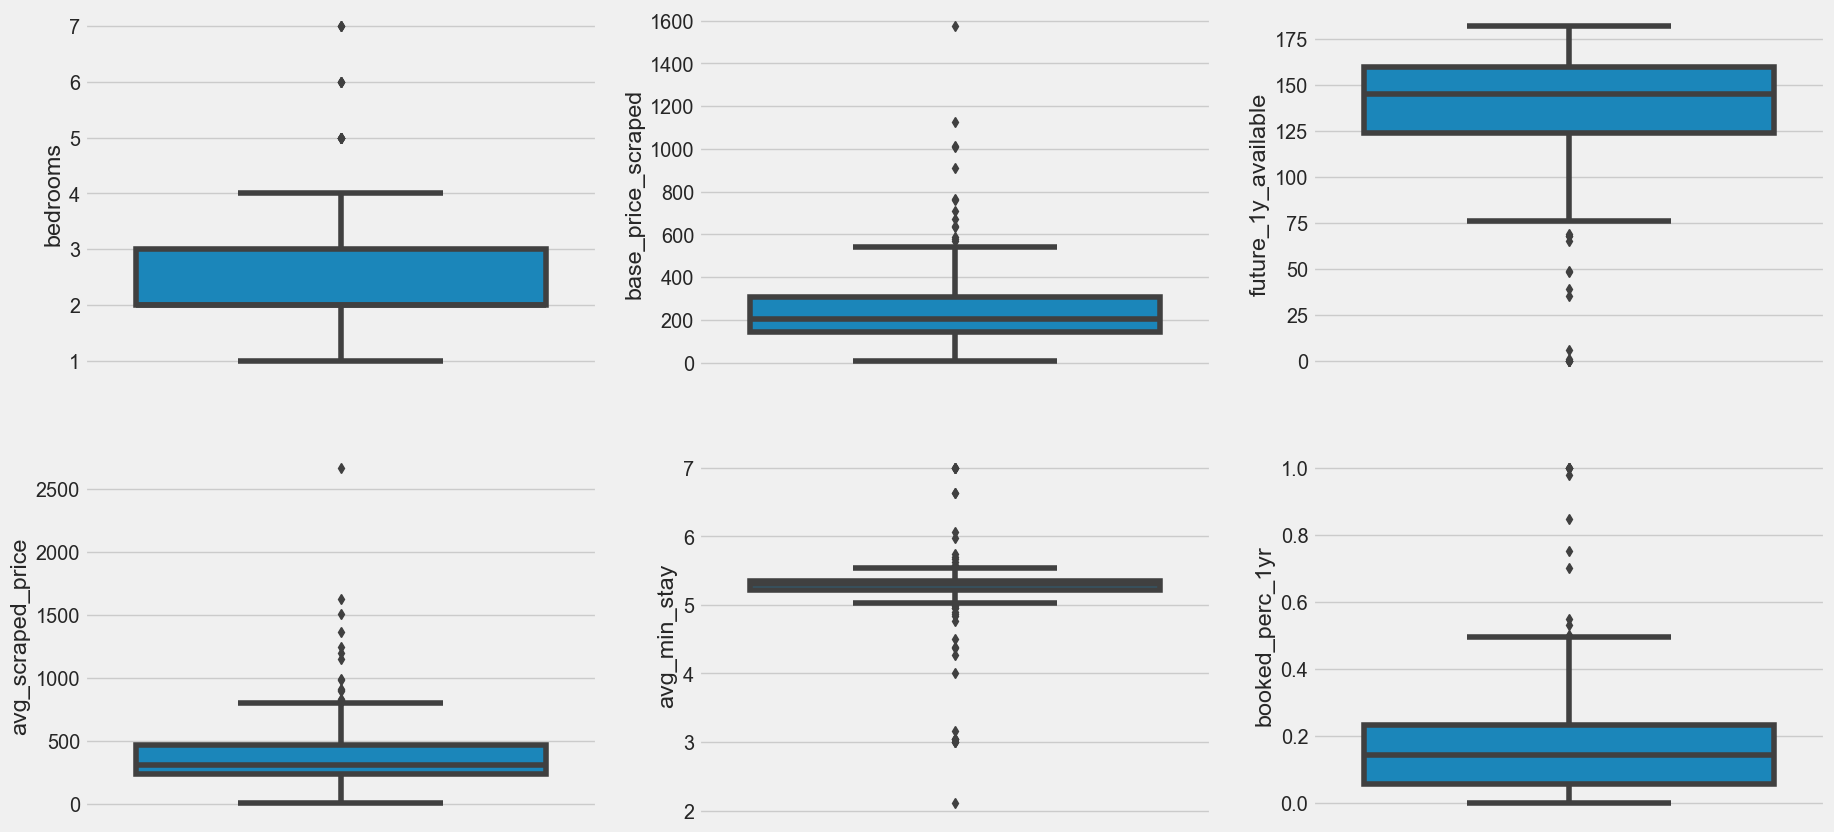

In [42]:
combined_availability = get_1y_availability.merge(get_1y_booked, on='master_listing_id')
combined_availability = combined_availability[['master_listing_id','future_1y_available',
                                               'avg_scraped_price','avg_min_stay','booked_perc_1yr']]
combined_availability = combined_availability.dropna()

# combined_availability = get_1y_availability.copy().dropna()
# combined_availability = combined_availability[['master_listing_id','future_1y_available',
#                                                'avg_scraped_price','avg_min_stay']]
prep_kmean = get_basic_info.copy()
prep_kmean = prep_kmean.merge(combined_availability, on='master_listing_id',how='left')
prep_kmean = prep_kmean.dropna()

_,axss = plt.subplots(2,3, figsize=[20,10])
sns.boxplot(y ='bedrooms',data=prep_kmean, ax=axss[0][0])
sns.boxplot(y ='base_price_scraped',data=prep_kmean, ax=axss[0][1])
sns.boxplot(y ='future_1y_available',data=prep_kmean, ax=axss[0][2])
sns.boxplot(y ='avg_scraped_price',data=prep_kmean, ax=axss[1][0])
sns.boxplot(y ='avg_min_stay',data=prep_kmean, ax=axss[1][1])
sns.boxplot(y ='booked_perc_1yr',data=prep_kmean, ax=axss[1][2])

<AxesSubplot: ylabel='booked_perc_1yr'>

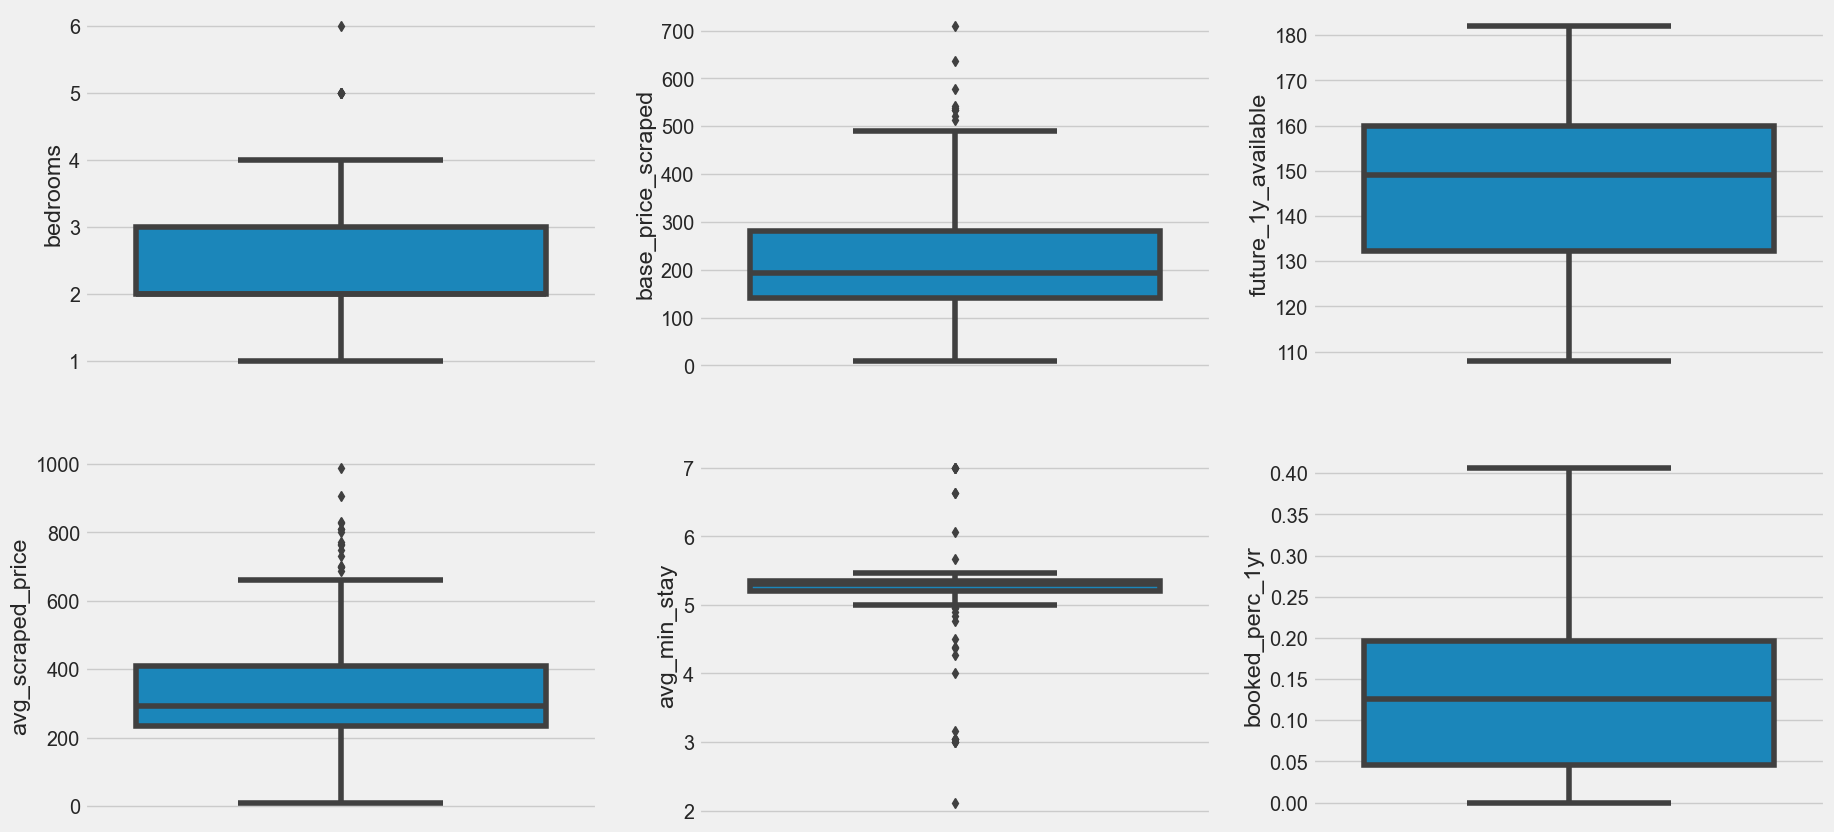

In [43]:
# Drop outlier
prep_kmean_numeric_wo_drop_outlier = prep_kmean.copy()

prep_kmean = prep_kmean[prep_kmean.avg_scraped_price < 1000]

for x in ['future_1y_available']:
    q75,q25 = np.percentile(prep_kmean.loc[:,x],[75,25])
    intr_qr = q75-q25
##     max = q75+(1.5*intr_qr)
    min = q25-(0.5*intr_qr) # 107
    prep_kmean.loc[prep_kmean[x] < min,x] = np.nan
    
prep_kmean = prep_kmean.dropna()
len(prep_kmean)

# boxplot for numerical feature
_,axss = plt.subplots(2,3, figsize=[20,10])
sns.boxplot(y ='bedrooms',data=prep_kmean, ax=axss[0][0])
sns.boxplot(y ='base_price_scraped',data=prep_kmean, ax=axss[0][1])
sns.boxplot(y ='future_1y_available',data=prep_kmean, ax=axss[0][2])
sns.boxplot(y ='avg_scraped_price',data=prep_kmean, ax=axss[1][0])
sns.boxplot(y ='avg_min_stay',data=prep_kmean, ax=axss[1][1])
sns.boxplot(y ='booked_perc_1yr',data=prep_kmean, ax=axss[1][2])

In [60]:
prep_kmean_encoder = prep_kmean.copy()
one_hot_encoded_data = pd.get_dummies(prep_kmean_encoder, columns = ['cluster'])
one_hot_encoded_data
# prep_kmean_numeric = one_hot_encoded_data.copy().dropna()
# prep_kmean_numeric = one_hot_encoded_data.merge(combined_availability, on='master_listing_id',how='left')
# # prep_kmean_numeric
# print(len(prep_kmean_numeric))

# prep_kmean_numeric = prep_kmean_numeric.drop(columns={'future_1y_available_y','avg_scraped_price_y','avg_min_stay_y','booked_perc_1yr_y'})
# prep_kmean_numeric = prep_kmean_numeric.rename(columns={'future_1y_available_x':'future_1y_available',
#                                                        'avg_scraped_price_x':'avg_scraped_price',
#                                                        'avg_min_stay_x':'avg_min_stay','booked_perc_1yr_x':'booked_perc_1yr'})


prep_kmean_no_index = prep_kmean_numeric.copy().dropna()
prep_kmean_no_index = prep_kmean_no_index.drop(columns=['master_listing_id'])
prep_kmean_no_index['bedrooms']=prep_kmean_no_index['bedrooms'].astype(int)
# prep_kmean_no_index.head()
print(len(prep_kmean_no_index))

186
186


Text(0.5, 1.0, 'visualization of raw data')

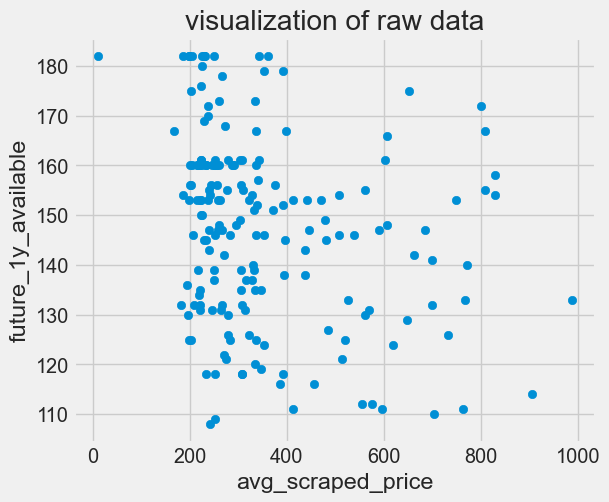

In [61]:
plt.figure(figsize = (6,5))
plt.scatter(prep_kmean_numeric.iloc[:,4],prep_kmean_numeric.iloc[:,3])
plt.xlabel('avg_scraped_price')
plt.ylabel('future_1y_available')
plt.title('visualization of raw data')

<AxesSubplot: >

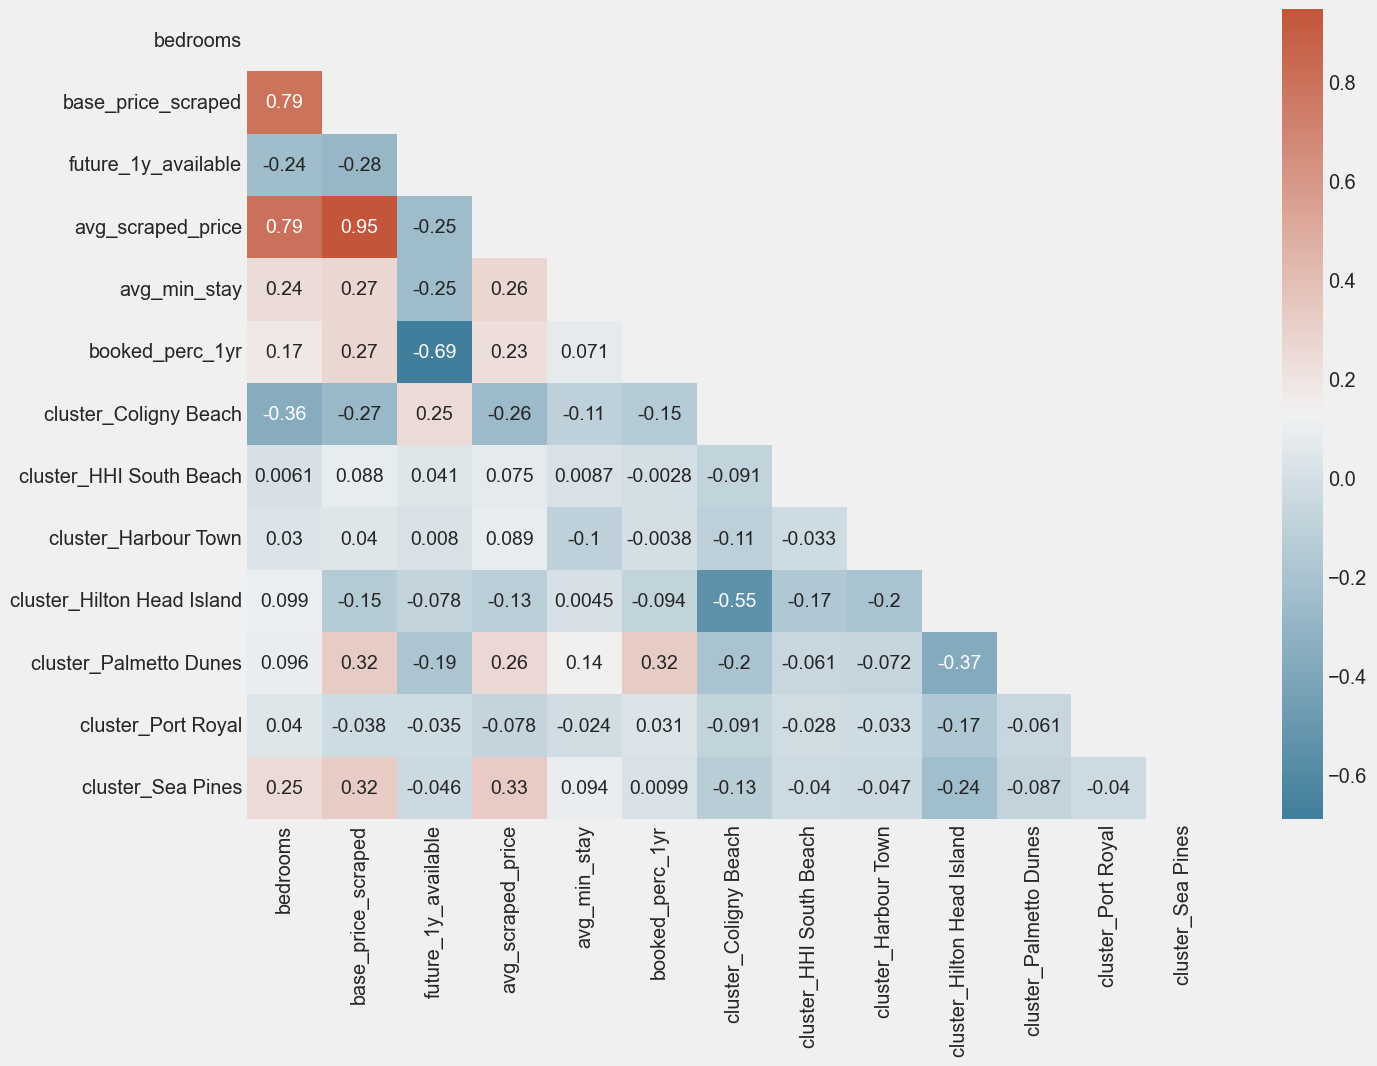

In [62]:
cormat = prep_kmean_no_index.corr()
f, ax = plt.subplots(figsize=(14, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(cormat, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cormat, annot=True, mask = mask, cmap=cmap)

In [48]:
# prep_kmean_no_index = prep_kmean_no_index[['bedrooms','future_1y_available_x','avg_scraped_price_x']]

In [63]:
prep_kmean_no_index_scaled=prep_kmean_no_index.copy()
prep_kmean_no_index_scaled[prep_kmean_no_index_scaled.columns] = StandardScaler().fit_transform(prep_kmean_no_index_scaled)
# print(prep_kmean_no_index_scaled.describe())
# prep_kmean_no_index_scaled.head()

df_scaled=prep_kmean_no_index_scaled.copy()
len(df_scaled)

186

In [64]:
df_scaled

,bedrooms,base_price_scraped,future_1y_available,avg_scraped_price,avg_min_stay,booked_perc_1yr,cluster_Coligny Beach,cluster_HHI South Beach,cluster_Harbour Town,cluster_Hilton Head Island,cluster_Palmetto Dunes,cluster_Port Royal,cluster_Sea Pines
0,1.476852,0.042506,-0.133615,0.230408,-0.603902,0.315500,-0.548361,-0.166206,-0.197753,0.989305,-0.366260,-0.166206,-0.238366
1,-1.609603,-0.891173,0.449276,-0.877456,-3.341091,0.120257,-0.548361,-0.166206,5.056820,-1.010811,-0.366260,-0.166206,-0.238366
2,0.448034,-0.341101,1.827020,-0.079074,-0.345340,-1.348309,-0.548361,-0.166206,-0.197753,0.989305,-0.366260,-0.166206,-0.238366
3,-0.580785,-0.646970,0.661237,-0.771143,0.153952,-0.105676,1.823618,-0.166206,-0.197753,-1.010811,-0.366260,-0.166206,-0.238366
4,-0.580785,-0.815485,1.827020,-0.968689,0.153952,-1.348309,-0.548361,-0.166206,-0.197753,0.989305,-0.366260,-0.166206,-0.238366
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,-0.580785,0.119859,-0.027635,0.512261,0.153952,-0.881038,1.823618,-0.166206,-0.197753,-1.010811,-0.366260,-0.166206,-0.238366
182,2.505670,2.828212,-0.769496,2.342693,-0.033282,0.889094,-0.548361,-0.166206,-0.197753,-1.010811,2.730301,-0.166206,-0.238366
183,-0.580785,-0.735914,-1.564348,-0.601628,0.742403,2.078344,-0.548361,-0.166206,-0.197753,0.989305,-0.366260,-0.166206,-0.238366
184,-1.609603,-0.447901,0.449276,-0.644186,-0.220517,0.120257,1.823618,-0.166206,-0.197753,-1.010811,-0.366260,-0.166206,-0.238366


# PCA

In [65]:
pca = PCA()
pca.fit(prep_kmean_no_index_scaled)

PCA()

Text(0, 0.5, 'Cumulative Explained Variance')

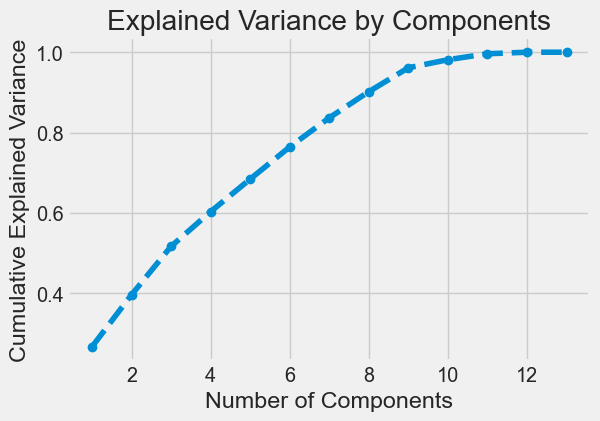

In [66]:
# pca.explained_variance_ratio_
plt.figure(figsize = (6,4))
plt.plot(range(1,14),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [67]:
# we choose seven components. 7 or 8 seems the right  choice according to the previous graph
pca = PCA(n_components = 8)

# fit the model with the selected number of components 
pca.fit(prep_kmean_no_index_scaled)

PCA(n_components=8)

In [68]:
scores_pca = pca.transform(prep_kmean_no_index_scaled)

# K-Means

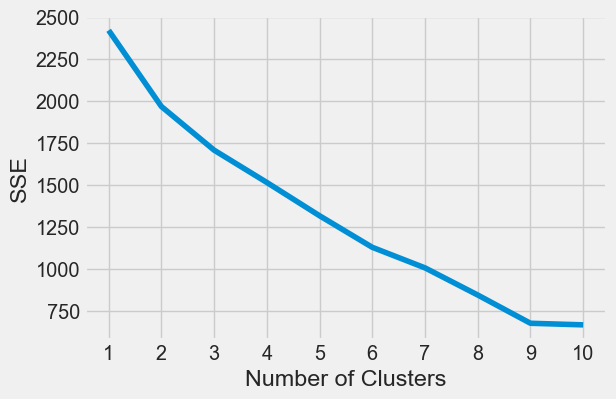

In [69]:
df = df_scaled
# df = scores_pca
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
 # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)
f, ax = plt.subplots(figsize=(6,4))    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [70]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

5

In [71]:
# we have chosen five clusters, so we run k-means with number of clusters equals four
# same initializer and random state as before
df = df_scaled #scores_pca
number_cluster_elbow = kl.elbow
kmeans_df = KMeans(n_clusters = number_cluster_elbow, init = 'k-means++', random_state=42)

# we fit our data with the k-means pca model
kmeans_df.fit(df)

KMeans(n_clusters=5, random_state=42)

In [24]:
# df_scaled['k-means']=kmeans_df.labels_

In [ ]:
# if number_cluster_elbow==4:
#     df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
#                                                                                   2:'third',3:'fourth'})
# elif number_cluster_elbow==5:
#     df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
#                                                                                   2:'third',3:'fourth',
#                                                                                   4:'fifth'}) 
# elif number_cluster_elbow==6:
#     df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
#                                                                                   2:'third',3:'fourth',
#                                                                                   4:'fifth',5:'sixth'})
# elif number_cluster_elbow==7:
#     df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
#                                                                                   2:'third',3:'fourth',
#                                                                                   4:'fifth',5:'sixth',
#                                                                                   6:'seventh'})    
# elif number_cluster_elbow==8:
#     df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
#                                                                                   2:'third',3:'fourth',
#                                                                                   4:'fifth',5:'sixth',
#                                                                                   6:'seventh',7:'eighth'}) 
# elif number_cluster_elbow==3:
#     df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
#                                                                                   2:'third'})

In [72]:
# Skip without PCA
# we create a new data frame with the original features and add the PCA scores and assigned clusters
df_segm_pca_kmeans = pd.concat([prep_kmean_numeric.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)
df_segm_pca_kmeans.columns.values[-8: ]=['component 1','component 2','component 3','component 4',
                                        'component 5','component 6','component 7','component 8']
df_segm_pca_kmeans['Segment k-means PCA']=kmeans_pca.labels_

ValueError: Length of values (188) does not match length of index (186)

In [17]:
# # Skip without PCA

if number_cluster_elbow==4:
    df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
                                                                                  2:'third',3:'fourth'})
elif number_cluster_elbow==5:
    df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
                                                                                  2:'third',3:'fourth',
                                                                                  4:'fifth'}) 
elif number_cluster_elbow==6:
    df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
                                                                                  2:'third',3:'fourth',
                                                                                  4:'fifth',5:'sixth'})
elif number_cluster_elbow==7:
    df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
                                                                                  2:'third',3:'fourth',
                                                                                  4:'fifth',5:'sixth',
                                                                                  6:'seventh'})    
elif number_cluster_elbow==8:
    df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
                                                                                  2:'third',3:'fourth',
                                                                                  4:'fifth',5:'sixth',
                                                                                  6:'seventh',7:'eighth'}) 
elif number_cluster_elbow==3:
    df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment k-means PCA'].map({0:'first',1:'second',
                                                                                  2:'third'})

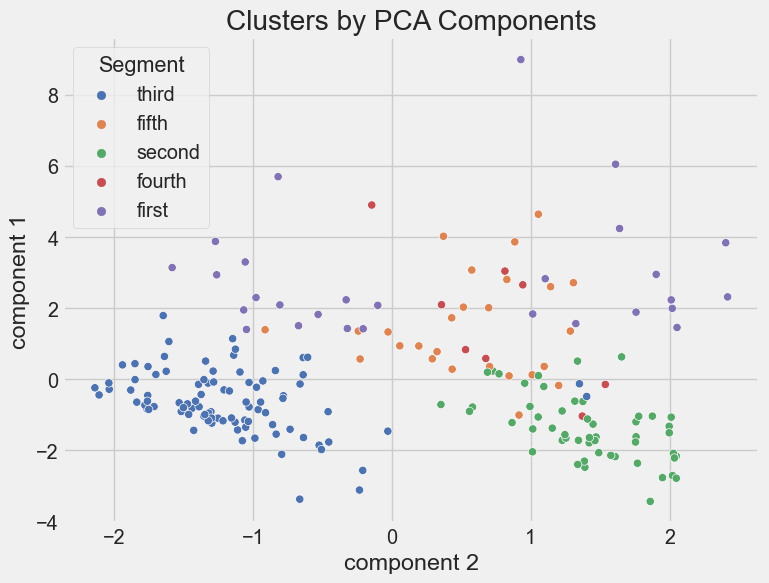

In [18]:
# visualize the segments with respect to the first two components 

# plot data by PCA components. The y axis is the first component, x axis is the second 
x_axis = df_segm_pca_kmeans['component 2']
y_axis = df_segm_pca_kmeans['component 1']
plt.figure(figsize=(8,6))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Segment'],palette="deep")
plt.title('Clusters by PCA Components')
plt.show()
# sns.color_palette("pastel")

In [19]:
exp_size = 25

k0 = round(exp_size*len(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==0])/len(df_segm_pca_kmeans))
c0 = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==0]['master_listing_id'].to_list()
n0 = random.sample(c0, k=k0)

k1 = round(exp_size*len(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==1])/len(df_segm_pca_kmeans))
c1 = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==1]['master_listing_id'].to_list()
n1 = random.sample(c1, k=k1)

k2 = round(exp_size*len(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==2])/len(df_segm_pca_kmeans))
c2 = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==2]['master_listing_id'].to_list()
n2 = random.sample(c2, k=k2)

k3 = round(exp_size*len(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==3])/len(df_segm_pca_kmeans))
c3 = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==3]['master_listing_id'].to_list()
n3 = random.sample(c3, k=k3)

if  number_cluster_elbow>=5:
    k4 = round(exp_size*len(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==4])/len(df_segm_pca_kmeans))
    c4 = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==4]['master_listing_id'].to_list()
    n4 = random.sample(c4, k=k4)
    
    if number_cluster_elbow>5:
        k5 = round(exp_size*len(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==5])/len(df_segm_pca_kmeans))
        c5 = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==5]['master_listing_id'].to_list()
        n5 = random.sample(c5, k=k5)    
    if number_cluster_elbow>6:
        k6 = round(exp_size*len(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==6])/len(df_segm_pca_kmeans))
        c6 = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==6]['master_listing_id'].to_list()
        n6 = random.sample(c6, k=k6)      
    if number_cluster_elbow>7:
        k7 = round(exp_size*len(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==7])/len(df_segm_pca_kmeans))
        c7 = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment k-means PCA']==7]['master_listing_id'].to_list()
        n7 = random.sample(c7, k=k7,replace=False)         

if number_cluster_elbow==4:    
    treatment = n0+n1+n2+n3    
elif number_cluster_elbow==5:    
    treatment = n0+n1+n2+n3+n4
elif number_cluster_elbow==6:
    treatment = n0+n1+n2+n3+n4+n5
elif number_cluster_elbow==7:
    treatment = n0+n1+n2+n3+n4+n5+n6
elif number_cluster_elbow==8:
    treatment = n0+n1+n2+n3+n4+n5+n6+n7
elif number_cluster_elbow==3:    
    treatment = n0+n1+n2
    
treatment_df = prep_kmean.copy()
treatment_df = treatment_df[treatment_df['master_listing_id'].isin(treatment)]
treatment_df['treatment']=1
# treatment_df.head()
len(treatment_df)
    

24

In [20]:
rest_df = prep_kmean.copy()
rest_df = rest_df[~rest_df['master_listing_id'].isin(treatment)]
rest_df['treatment'] = 0

combined_df = pd.concat([treatment_df, rest_df])
# combined_df
len(combined_df)

206

# Post-KMeans analysis

<AxesSubplot: xlabel='booked_perc_1yr', ylabel='Density'>

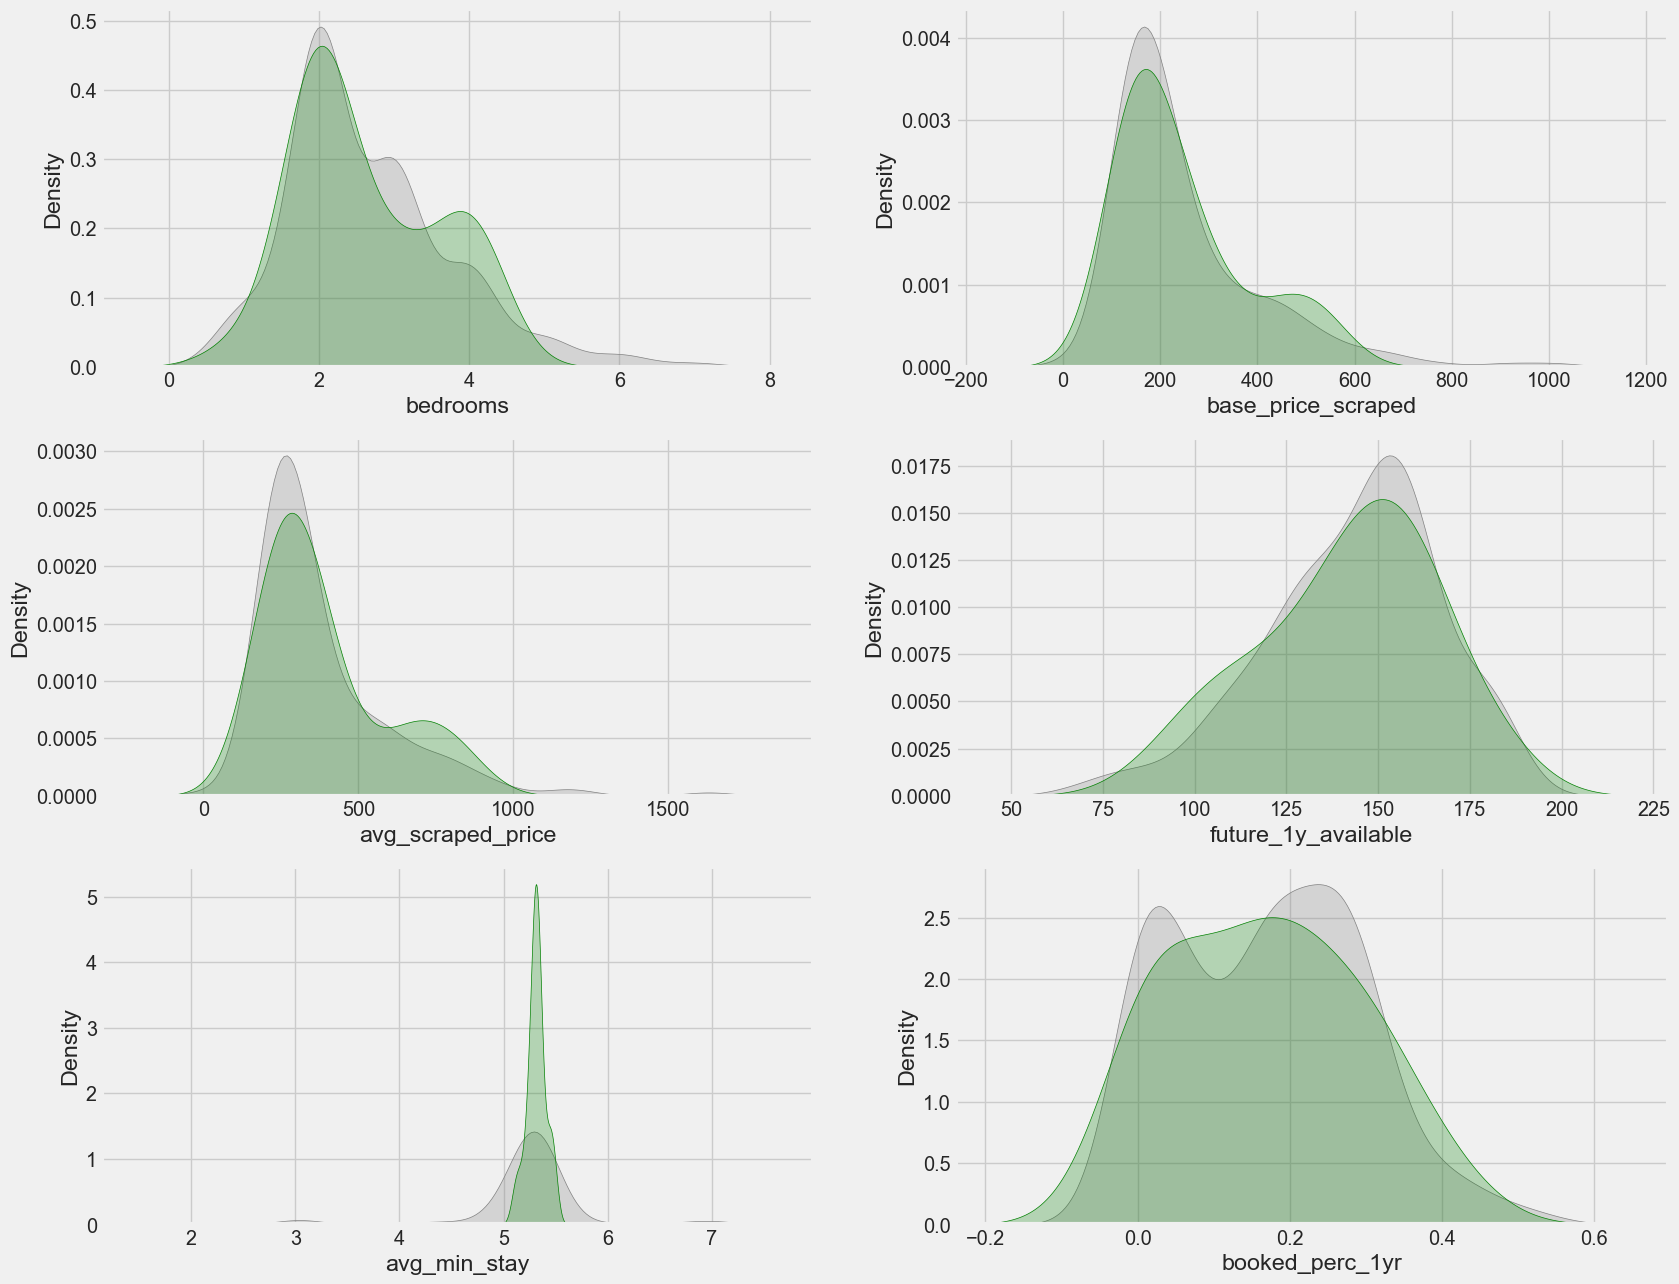

In [21]:
C_COLOUR = 'grey'
T_COLOUR = 'green'
C_LABEL = 'Control'
T_LABEL = 'Treatment'
fig, ax = plt.subplots(3,2,figsize=(18,15))
    # Visualise original distribution
sns.kdeplot(data=combined_df[combined_df['treatment']==0], x='bedrooms', fill=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[0][0])
sns.kdeplot(data=combined_df[combined_df['treatment']==1], x='bedrooms', fill=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[0][0])
sns.kdeplot(data=combined_df[combined_df['treatment']==0], x='base_price_scraped', fill=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[0][1])
sns.kdeplot(data=combined_df[combined_df['treatment']==1], x='base_price_scraped', fill=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[0][1])
sns.kdeplot(data=combined_df[combined_df['treatment']==0], x='avg_scraped_price', fill=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[1][0])
sns.kdeplot(data=combined_df[combined_df['treatment']==1], x='avg_scraped_price', fill=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[1][0])
sns.kdeplot(data=combined_df[combined_df['treatment']==0], x='future_1y_available', fill=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[1][1])
sns.kdeplot(data=combined_df[combined_df['treatment']==1], x='future_1y_available', fill=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[1][1])
sns.kdeplot(data=combined_df[combined_df['treatment']==0], x='avg_min_stay', fill=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[2][0])
sns.kdeplot(data=combined_df[combined_df['treatment']==1], x='avg_min_stay', fill=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[2][0])
sns.kdeplot(data=combined_df[combined_df['treatment']==0], x='booked_perc_1yr', fill=True, 
            color=C_COLOUR, label=C_LABEL, ax=ax[2][1])
sns.kdeplot(data=combined_df[combined_df['treatment']==1], x='booked_perc_1yr', fill=True, 
            color=T_COLOUR, label=T_LABEL, ax=ax[2][1])

# PSM (Propensity Score Matching)

In [22]:
matching_df = combined_df.copy()
matching_df = pd.get_dummies(matching_df, columns = ['cluster'])
print(len(matching_df))
matching_df_no_index = matching_df.copy()
matching_df_no_index = matching_df_no_index.drop(columns=['master_listing_id','treatment'])
matching_df_no_index_scaled = matching_df_no_index.copy()
matching_df_no_index_scaled[matching_df_no_index_scaled.columns] = StandardScaler().fit_transform(matching_df_no_index_scaled)
print(len(matching_df_no_index_scaled))
listing_id_list = matching_df.copy()
listing_id_list = listing_id_list[['master_listing_id','treatment']]
matching_df_scaled = pd.concat([listing_id_list,matching_df_no_index_scaled],axis=1) 
print(len(matching_df_scaled))


206
206
206


In [23]:
psm = PsmPy(matching_df_scaled, treatment='treatment', indx='master_listing_id', exclude = [])

In [24]:
psm.logistic_ps(balance = True)

In [25]:
psm.predicted_data.head()

,master_listing_id,bedrooms,base_price_scraped,future_1y_available,avg_scraped_price,avg_min_stay,booked_perc_1yr,cluster_Coligny Beach,cluster_HHI South Beach,cluster_Harbour Town,cluster_Hilton Head Island,cluster_Palmetto Dunes,cluster_Port Royal,cluster_Sea Pines,propensity_score,propensity_logit,treatment
0,1160714,-0.619155,-0.595574,-0.885755,-0.509028,0.334512,1.984819,-0.513618,-0.201008,-0.187552,0.990338,-0.388379,-0.173205,-0.237508,0.582350,0.332430,1
1,1160731,-0.619155,0.178928,-2.194509,0.058057,0.138712,1.354251,-0.513618,-0.201008,-0.187552,-1.009756,2.574807,-0.173205,-0.237508,0.659093,0.659257,1
2,1160743,-0.619155,-0.752599,-0.505795,-0.732131,0.138712,1.009544,-0.513618,-0.201008,-0.187552,0.990338,-0.388379,-0.173205,-0.237508,0.570700,0.284708,1
3,1160756,1.256520,1.258274,-1.350152,1.199216,0.203978,-0.893601,-0.513618,4.974937,-0.187552,-1.009756,-0.388379,-0.173205,-0.237508,0.761952,1.163413,1
4,1160763,1.256520,1.911128,0.507434,1.978945,0.017502,-0.444692,-0.513618,-0.201008,-0.187552,0.990338,-0.388379,-0.173205,-0.237508,0.492835,-0.028664,1


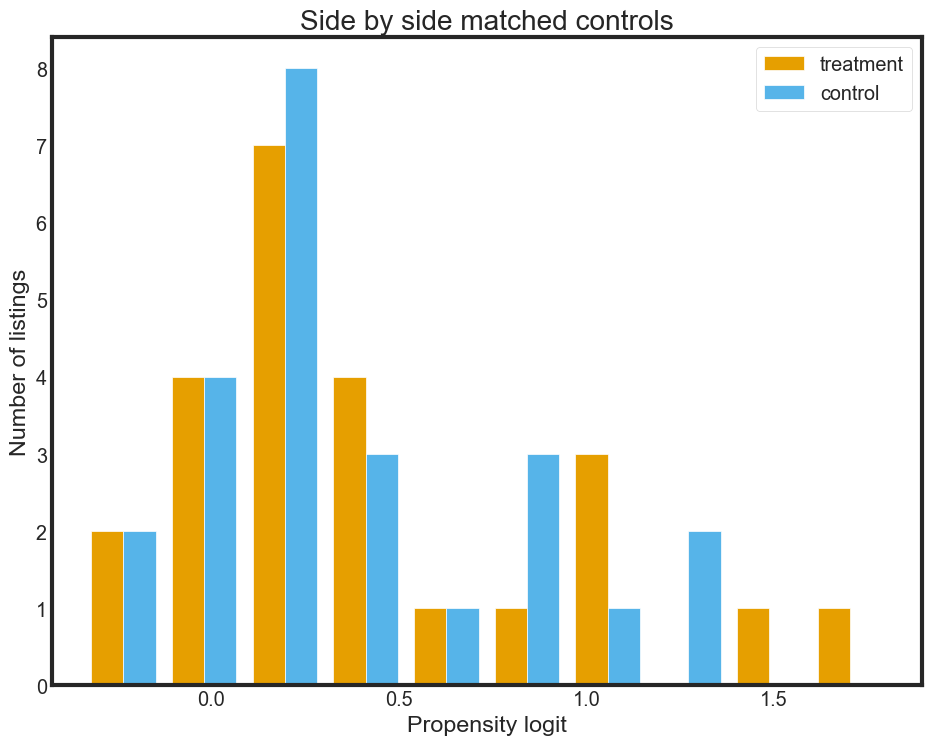

In [26]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)
# psm.knn_matched_12n(matcher='propensity_logit', how_many=1)
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of listings', 
               Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)

In [27]:
matched_ids_list= psm.matched_ids
len(matched_ids_list)

24

# Analysis

In [28]:
treatment_matching = matched_ids_list.merge(combined_df, on='master_listing_id', how='left')
# treatment_matching.head()
print(len(treatment_matching))

control_matching = matched_ids_list.merge(combined_df, left_on='matched_ID',right_on='master_listing_id', how='left')
# control_matching.head()
print(len(control_matching))

24
24


In [29]:
matching_compare = treatment_matching.merge(control_matching, left_on=['master_listing_id','matched_ID'],
                                                              right_on=['master_listing_id_x','matched_ID'])

matching_compare = matching_compare[['master_listing_id','cluster_x','bedrooms_x', 'avg_scraped_price_x',
                                     'treatment_x','base_price_scraped_x','future_1y_available_x', 
                                     'booked_perc_1yr_x',
                                     'matched_ID','cluster_y','bedrooms_y', 'avg_scraped_price_y',
                                     'treatment_y','base_price_scraped_y','future_1y_available_y', 'booked_perc_1yr_y']]

matching_compare = matching_compare.rename(columns={'master_listing_id':'treatment_id',
                                                   'bedrooms_x':'bedrm_t', 
                                                    'base_price_scraped_x':'base_price_t',
                                                    'cluster_x':'cluster_t',
                                                    'cluster_y':'cluster_c',
                                                    'matched_ID':'control_id',
                                                   'bedrooms_y':'bedrm_c',
                                                   'base_price_scraped_y':'base_price_c',
                                                   'base_price_scraped_x':'base_price_t',
                                                   'future_1y_available_x':'1yr_ava_t',
                                                   'future_1y_available_y':'1yr_ava_c',
                                                   'avg_scraped_price_x':'avg_scp_price_t',
                                                   'avg_scraped_price_y':'avg_scp_price_c'})

matching_compare = matching_compare.drop(columns=['treatment_x', 'treatment_y'])

In [30]:
# matching_compare.to_csv('/Users/lingyicai/desktop/Trial_AB_sampling/matching_02.csv')
matching_compare

,treatment_id,cluster_t,bedrm_t,avg_scp_price_t,base_price_t,1yr_ava_t,booked_perc_1yr_x,control_id,cluster_c,bedrm_c,avg_scp_price_c,base_price_c,1yr_ava_c,booked_perc_1yr_y
0,1160714,Hilton Head Island,2.0,270.108242,159.1590,122.0,0.413105,1162226,Hilton Head Island,2.0,309.967033,204.470000,155.0,0.070381
1,1160731,Palmetto Dunes,2.0,393.098901,276.2970,91.0,0.335548,1162230,Hilton Head Island,2.0,251.387143,142.873500,118.0,0.412791
2,1160743,Hilton Head Island,2.0,221.721154,135.4100,131.0,0.293151,1162203,Palmetto Dunes,3.0,771.228022,522.406499,147.0,0.197260
3,1160756,HHI South Beach,4.0,640.596154,439.5405,111.0,0.059072,1160829,Hilton Head Island,2.0,246.537088,146.254500,131.0,0.175595
4,1160763,Hilton Head Island,4.0,809.705769,538.2800,155.0,0.114286,1160893,Palmetto Dunes,3.0,322.821044,217.444500,126.0,0.353276
5,1160779,Hilton Head Island,2.0,250.782747,134.2320,160.0,0.183844,1162323,Harbour Town,4.0,748.887363,490.430000,153.0,0.025641
6,1160791,Hilton Head Island,4.0,305.646978,296.9295,156.0,0.028807,1162246,Hilton Head Island,2.0,251.573956,162.918000,109.0,0.052632
7,1160866,Palmetto Dunes,4.0,685.972527,520.4115,147.0,0.095890,1162339,Palmetto Dunes,2.0,331.714286,234.700000,151.0,0.106061
8,1160840,Coligny Beach,2.0,222.123626,140.2065,132.0,0.267062,1162314,Sea Pines,5.0,906.392747,534.360000,114.0,0.154574
9,1160841,Sea Pines,4.0,828.602198,468.0375,154.0,0.197260,1162239,Palmetto Dunes,5.0,767.395604,577.510500,133.0,0.275964


In [31]:
control_matching_simplify = control_matching.drop(columns=['master_listing_id_x', 'master_listing_id_y'])
# control_matching_simplify.head()
treatment_matching_simplify = treatment_matching.drop(columns=['matched_ID'])
# treatment_matching_simplify.head()
control_matching_simplify = control_matching_simplify.rename(columns={'matched_ID':'master_listing_id'})
match_combine_plot = pd.concat([treatment_matching_simplify,control_matching_simplify])
match_combine_plot = match_combine_plot.reset_index(drop=True)
len(match_combine_plot)

48

<AxesSubplot: xlabel='treatment', ylabel='count'>

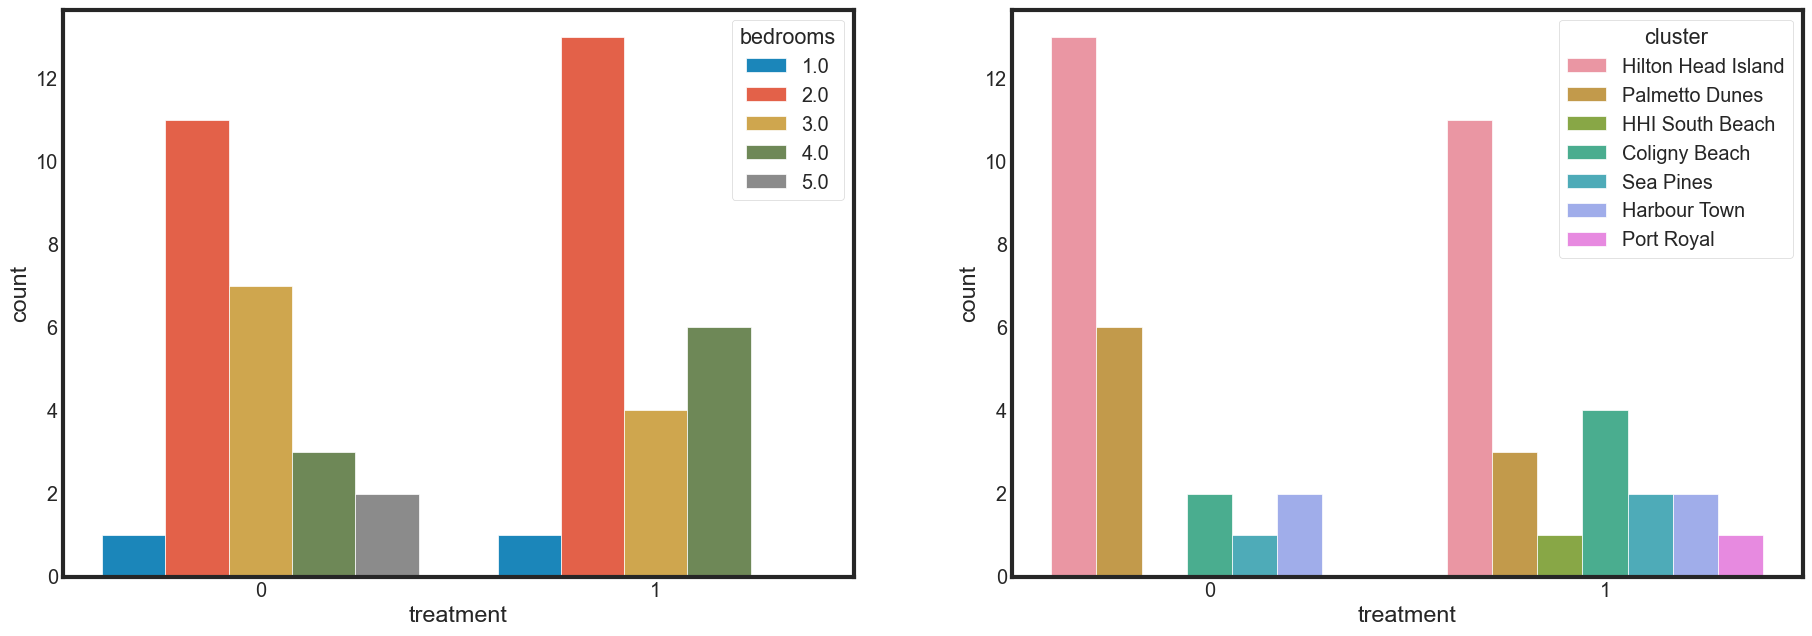

In [32]:
_,axss = plt.subplots(1,2, figsize=[20,7])
sns.countplot(x='treatment', hue='bedrooms', data=match_combine_plot, ax=axss[0])
sns.countplot(x='treatment', hue='cluster', data=match_combine_plot, ax=axss[1])

<AxesSubplot: xlabel='treatment', ylabel='booked_perc_1yr'>

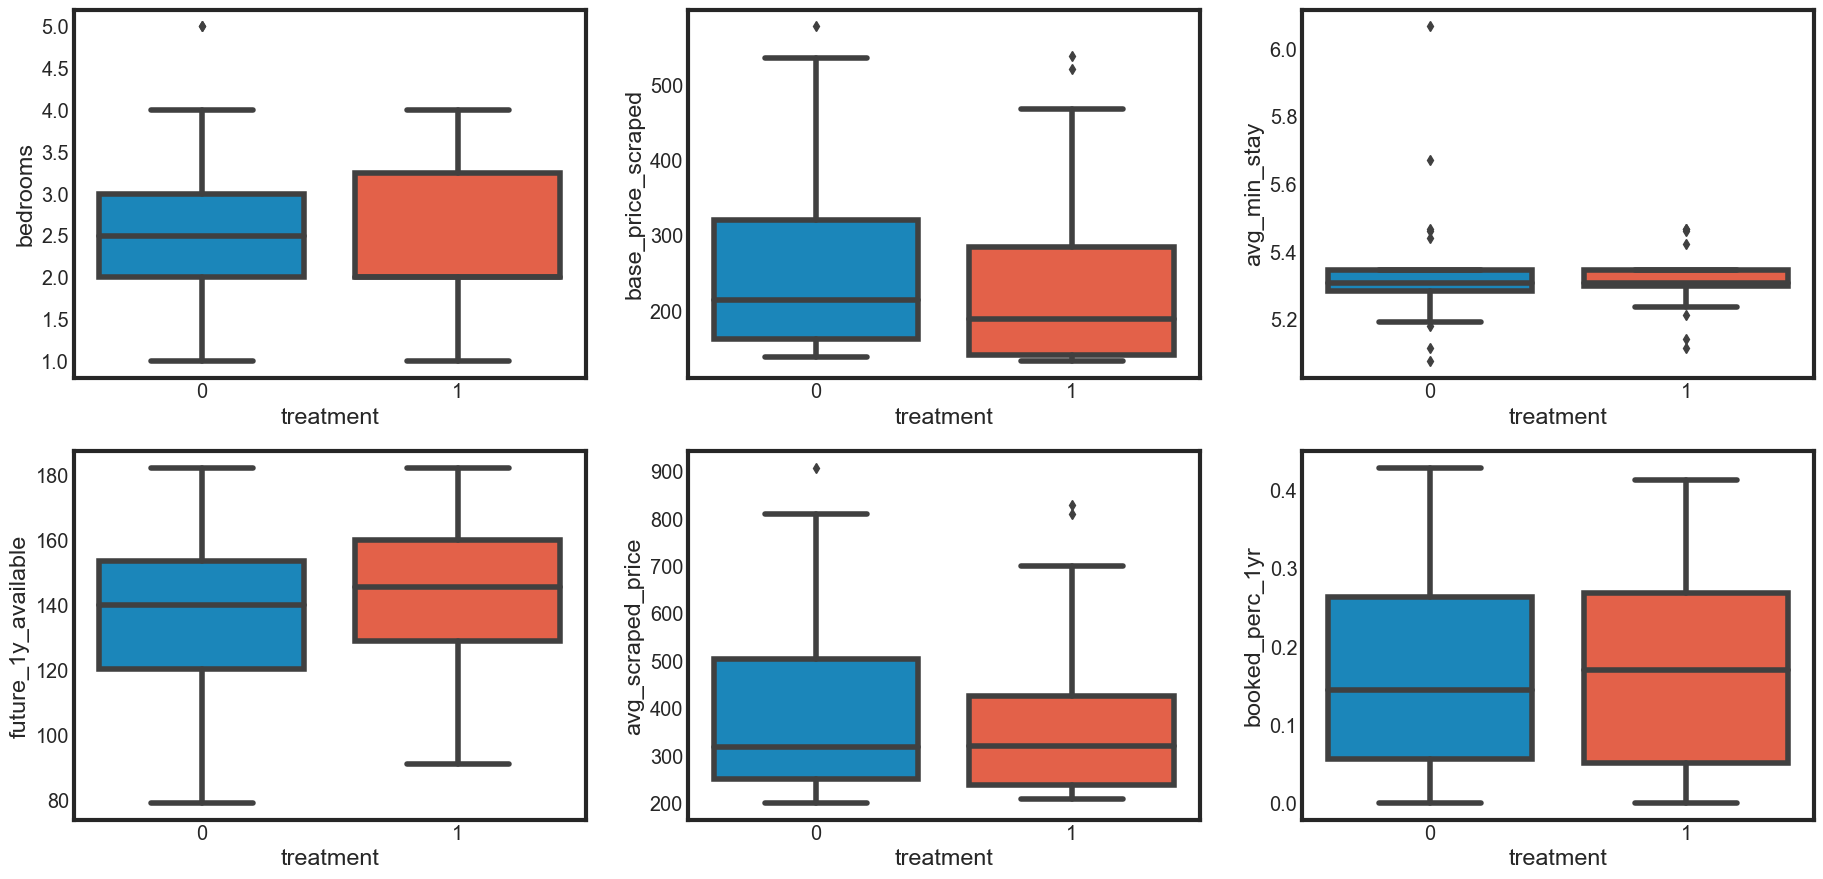

In [33]:
# boxplot for numerical feature
_,axss = plt.subplots(2,3, figsize=[20,10])
sns.boxplot(x='treatment', y ='bedrooms', data=match_combine_plot, ax=axss[0][0])
sns.boxplot(x='treatment', y ='base_price_scraped', data=match_combine_plot, ax=axss[0][1])
sns.boxplot(x='treatment', y ='avg_min_stay', data=match_combine_plot, ax=axss[0][2])
sns.boxplot(x='treatment', y ='future_1y_available', data=match_combine_plot, ax=axss[1][0])
sns.boxplot(x='treatment', y ='avg_scraped_price', data=match_combine_plot, ax=axss[1][1])
sns.boxplot(x='treatment', y ='booked_perc_1yr', data=match_combine_plot, ax=axss[1][2])

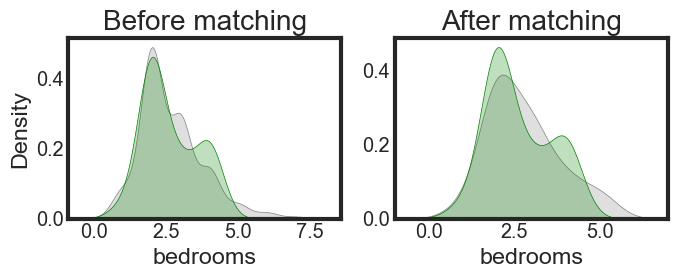

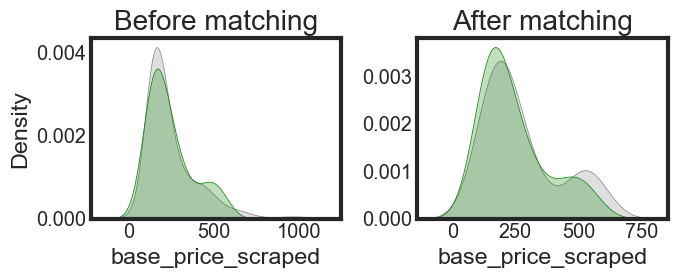

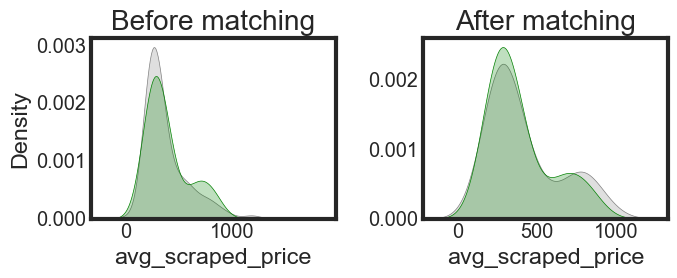

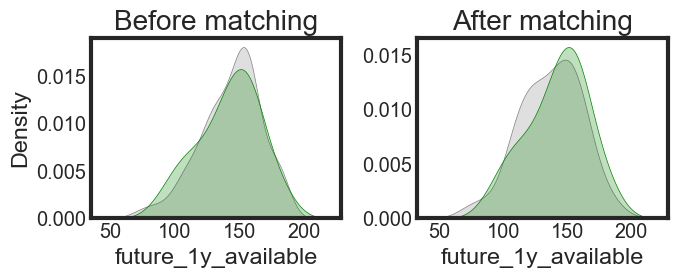

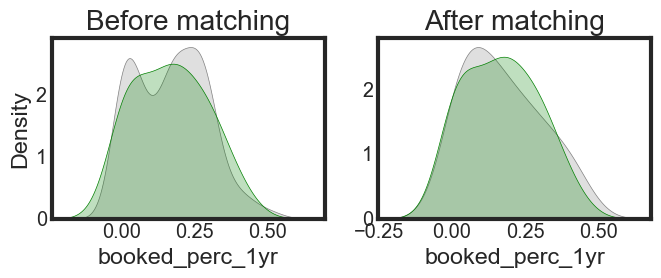

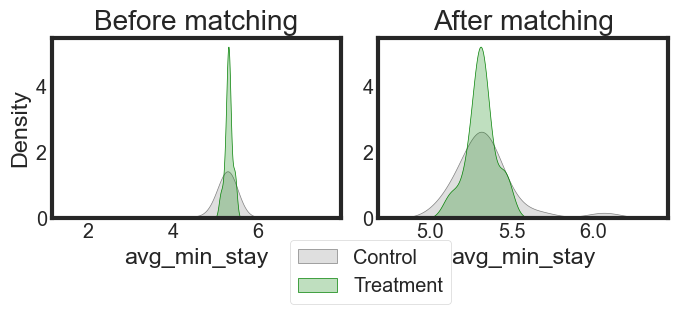

In [34]:
for var in ['bedrooms', 'base_price_scraped','avg_scraped_price','future_1y_available','booked_perc_1yr','avg_min_stay']:
    fig, ax = plt.subplots(1,2,figsize=(7,3))
    # Visualise original distribution
    sns.kdeplot(data=combined_df[combined_df['treatment']==0], x=var, fill=True, 
                color=C_COLOUR, label=C_LABEL, ax=ax[0])
    sns.kdeplot(data=combined_df[combined_df['treatment']==1], x=var, fill=True, 
                color=T_COLOUR, label=T_LABEL, ax=ax[0])
    ax[0].set_title('Before matching')
    
    # Visualise new distribution
    sns.kdeplot(data=match_combine_plot[match_combine_plot['treatment']==0], x=var, 
                fill=True, color=C_COLOUR, label=C_LABEL, ax=ax[1])
    sns.kdeplot(data=match_combine_plot[match_combine_plot['treatment']==1], x=var, 
                fill=True, color=T_COLOUR, label=T_LABEL, ax=ax[1])
    ax[1].set_title('After matching')
    ax[1].set_ylabel("")
    plt.tight_layout()
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3));

In [35]:
tt_bp = ttest_ind(control_matching_simplify['base_price_scraped'], treatment_matching_simplify['base_price_scraped'])
tt_sp = ttest_ind(control_matching_simplify['avg_scraped_price'], treatment_matching_simplify['avg_scraped_price'])
tt_ava = ttest_ind(control_matching_simplify['future_1y_available'], treatment_matching_simplify['future_1y_available'])
tt_bd = ttest_ind(control_matching_simplify['bedrooms'], treatment_matching_simplify['bedrooms'])
tt_bperc = ttest_ind(control_matching_simplify['booked_perc_1yr'], treatment_matching_simplify['booked_perc_1yr'])
tt_ms = ttest_ind(control_matching_simplify['avg_min_stay'], treatment_matching_simplify['avg_min_stay'])
print('base_price:','\t',tt_bp)
print('avg_price:','\t',tt_sp)
print('availabile_nt:','\t',tt_ava)
print('bedrooms:','\t',tt_bd)
print('booked perc:','\t',tt_bperc)
print('min_stay:','\t',tt_ms)

base_price: 	 Ttest_indResult(statistic=0.679170973471614, pvalue=0.5004327889001157)
avg_price: 	 Ttest_indResult(statistic=0.3976059422270541, pvalue=0.6927598229247811)
availabile_nt: 	 Ttest_indResult(statistic=-0.720807038283376, pvalue=0.4746756642710347)
bedrooms: 	 Ttest_indResult(statistic=0.4421169778421965, pvalue=0.660476289102454)
booked perc: 	 Ttest_indResult(statistic=0.12507272712024245, pvalue=0.9010109825093146)
min_stay: 	 Ttest_indResult(statistic=0.7843962185658415, pvalue=0.43682855162617695)
